### Load Mujoco Engine

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r, get_interp_const_vel_traj
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[3.1.4]


### Parse

In [2]:
xml_path = '../../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[60]
n_geom:[52]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[29]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylin

### Get gripper joint indexes

In [3]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] not in list1:
        idxs_step.append(list1.index(list2[i]))
        
gripper_joint_idxs = []

for gripper_idx in env.rev_joint_idxs:
    if gripper_idx in env.idxs_forward:
        gripper_joint_idxs.append(gripper_idx)
print(f"Gripper joint idxs: {gripper_joint_idxs}")

Gripper joint idxs: [0, 1, 2, 3, 4, 5]


In [4]:
q_init = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]
q_close_grasp = [-0.03, -0.0273, -0.03, 0.03, 0.0273, 0.03]

## Augmented Jacobian Inverse Kinematics

In [5]:
import math
PI = math.pi

env.init_viewer(viewer_title='IK using UR',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36])
env.update_viewer(VIS_TRANSPARENT=False) # transparent
env.reset() # reset

env.forward(q=q_init,joint_idxs=env.idxs_forward)

# Set (multiple) IK targets
ik_body_names = ['tcp_link','wrist_3_link']
ik_p_trgts = [env.get_p_body(body_name='wrist_3_link')+np.array([0.35, 0.0, 0.25]),
              env.get_p_body(body_name='wrist_3_link')+np.array([0.2, 0.2, 0.2])]
ik_R_trgts = [rpy2r(np.array([0, 1.0*PI, -0.5 *PI])),
              rpy2r(np.array([0, 1.0*PI, -0.5 *PI]))]
IK_Ps = [True,True]
IK_Rs = [False,False]

# Loop
q = env.get_q(joint_idxs=env.idxs_jacobian)

imgs,img_ticks,max_tick = [],[],1000
while (env.tick < max_tick) and env.is_viewer_alive():
    # Numerical IK
    J_aug,err_aug = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        p_trgt,R_trgt = ik_p_trgts[ik_idx],ik_R_trgts[ik_idx]
        IK_P,IK_R = IK_Ps[ik_idx],IK_Rs[ik_idx]
        J,err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=IK_P,IK_R=IK_R)
        if (J is None) and (err is None): continue
        if len(J_aug) == 0:
            J_aug,err_aug = J,err
        else:
            J_aug   = np.concatenate((J_aug,J),axis=0)
            err_aug = np.concatenate((err_aug,err),axis=0)
    dq = env.damped_ls(J_aug,err_aug,stepsize=1,eps=1e-1,th=5*np.pi/180.0)

    # Update q and FK
    q = q + dq[env.idxs_jacobian]
    env.forward(q=q,joint_idxs=env.idxs_forward)

    # Render
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        p_trgt,R_trgt = ik_p_trgts[ik_idx],ik_R_trgts[ik_idx]
        IK_P,IK_R = IK_Ps[ik_idx],IK_Rs[ik_idx]
        if (IK_P is None) and (IK_R is None): continue
        env.plot_T(p=env.get_p_body(body_name=ik_body_name),R=env.get_R_body(body_name=ik_body_name),
                   PLOT_AXIS=IK_R,axis_len=0.2,axis_width=0.01,
                   PLOT_SPHERE=IK_P,sphere_r=0.05,sphere_rgba=[1,0,0,0.9])
        env.plot_T(p=p_trgt,R=R_trgt,
                   PLOT_AXIS=IK_R,axis_len=0.2,axis_width=0.01,
                   PLOT_SPHERE=IK_P,sphere_r=0.05,sphere_rgba=[0,0,1,0.9])
    env.plot_T(p=[0,0,0],R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0)
    env.render()
    # Print and save image 
    if (env.tick)%(max_tick//10)==0 or (env.tick==1):
        print ("[%d/%d] IK error:[%.4f]"%(env.tick,max_tick,np.linalg.norm(err_aug)))
        img = env.grab_image()
        imgs.append(img)
        img_ticks.append(env.tick)

# Close viewers
env.close_viewer()
print ("Done.")

[100/1000] IK error:[0.0128]
[200/1000] IK error:[0.0107]
[300/1000] IK error:[0.0106]
Pressed ESC
Quitting.
Done.


2025-06-13 11:36:41.351 python[71312:292865] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


### Using a function: `solve_augmented_ik`

In [6]:
env.init_viewer(viewer_title='IK using UR',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36])
env.update_viewer(VIS_TRANSPARENT=False) # transparent
env.reset() # reset

q_aug_ik = env.solve_augmented_ik(ik_body_names = ['tcp_link','wrist_3_link'],
                    ik_p_trgts=[np.array([0.88, 0.3, 1.2]), np.array([0.6,0.3,1.2])],
                    ik_R_trgts=[rpy2r(np.array([0, 1 * np.pi, -0.5 *np.pi])), rpy2r(np.array([0, 0, 0]))],
                    IK_Ps = [True,True], IK_Rs = [True,False],
                    q_init=q_init, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
                    RESET=True,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-2)

# Close viewers
env.close_viewer()
print ("Done.")
q_aug_ik

Done.


array([-2.48, -3.09,  0.88,  2.21, -0.91, -0.  ])

In [7]:
times,q_aug_traj = get_interp_const_vel_traj(
    np.vstack((q_init,q_aug_ik)),vel=np.radians(20),HZ=env.HZ)
print ("Joint trajectory ready. duration:[%.2f]sec"%(times[-1]))

traj_aug_len = q_aug_traj.shape[0]

Joint trajectory ready. duration:[4.86]sec


Pressed ESC
Quitting.


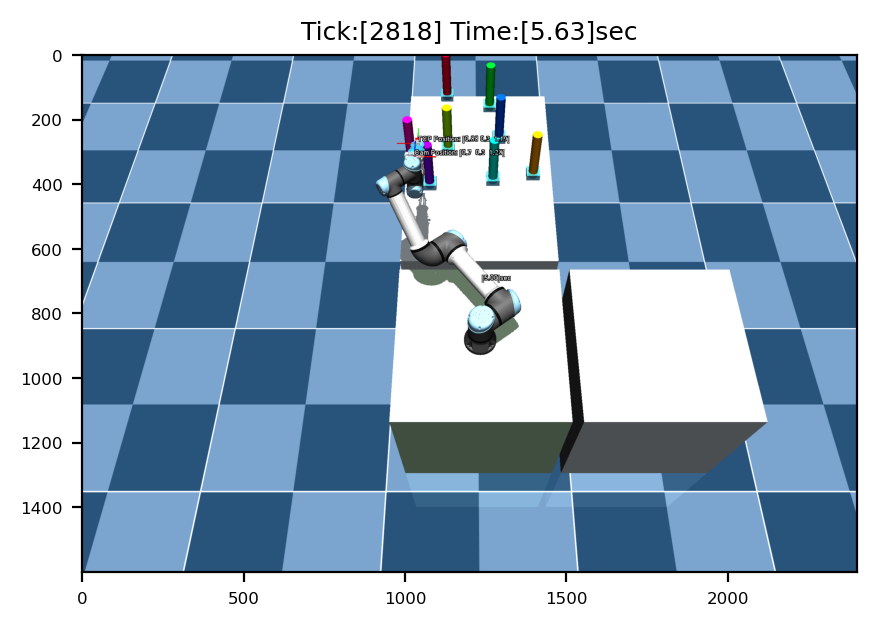

Done.


In [8]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=q_init,joint_idxs=env.idxs_forward)

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    
    if tick >= traj_aug_len-1:
        q = q_aug_traj[-1,:]
    else:
        q = q_aug_traj[tick,:]
        
    env.step(ctrl=q, ctrl_idxs=env.idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")